In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

### Генерация данных о сессиях пользователей

Будем генерировать пользователей со случайным количеством сессий от 3 до 9. У каждого пользователя будет своя средняя длина сессии, множество сессий пользователя будет генерироваться просто добавлением шума к средней длине сессии пользователя.

In [2]:
def get_session_duration(size, effect=0, seed=None):
    """Генерирует данные с продолжительностями сессий.
    
    size: int, количество пользователей.
    effect: float, размер эффекта, на сколько изменилась продолжительность сессии относительно базовой.
    seed: int, состоянеие генератора случайных чисел
    
    return: List[np.array], список массивов,
        элемент списка - пользователь,
        элементы массива - длины сессий.
    """
    def _user_sessions(mean):
        size = np.random.randint(3,10)
        duration = np.random.normal(loc=mean, scale=10, size=size).round()
        duration = np.where(duration > 0, duration, 0)
        return duration
    
    if seed:
        np.random.seed(seed)
    
    mean_durations = np.random.normal(loc=100, scale=20, size=size) * (1 + effect)
    return [_user_sessions(mean) for mean in mean_durations]

In [4]:
get_session_duration(5, effect=0, seed=None)

[array([145., 124., 130., 124., 119., 113., 129.]),
 array([106., 117., 126., 140., 134.]),
 array([86., 61., 95., 57., 63., 71.]),
 array([111.,  96., 102., 102.]),
 array([115., 118., 101., 108., 101.])]

# AA-тест и распределение p-value

Корректно работающий тест дает равномерное распределение p-value для AA-теста.  Действительно, p-value показывает вероятность получить такое-же или большее значение статистики при справедливости нулевой гипотезы. Из этого автоматически следует выше написанное утверждение.

In [5]:
def plot_pvalue_ecdf(pvalues, title=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if title:
        plt.suptitle(title)

    sns.histplot(pvalues, ax=ax1, bins=20, stat='density')
    ax1.plot([0,1],[1,1], 'k--')
    ax1.set_xlabel('p-value')

    sns.ecdfplot(pvalues, ax=ax2)
    ax2.set_ylabel('Probability')
    ax2.set_xlabel('p-value')
    ax2.grid()

  0%|          | 0/5000 [00:00<?, ?it/s]

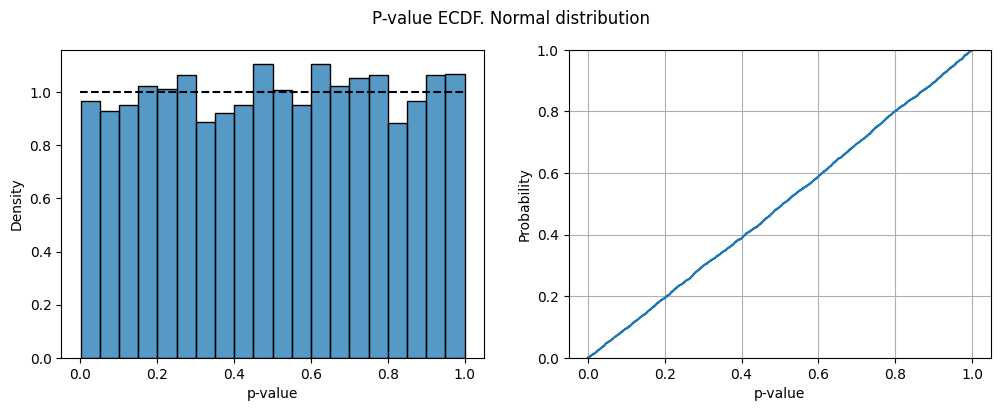

In [6]:
def get_pvalue_samples(a_sample_generator, b_sample_generator, size=1000):
    pvalues = []
    for _ in tqdm(range(size)):
        _, p = stats.ttest_ind(a_sample_generator(), b_sample_generator())
        pvalues.append(p)
    return pvalues

pvalues = get_pvalue_samples(
    a_sample_generator=lambda: np.random.normal(loc=0, scale=1, size=100),
    b_sample_generator=lambda: np.random.normal(loc=0, scale=1, size=100),
    size=5000
)

plot_pvalue_ecdf(pvalues, title='P-value ECDF. Normal distribution')

# 2. Тест Стьюдента по сессиям. Проблема зависимости данных

Посмотрим что произойдет с тестом при наивном применении. Когда мы в качестве случайных величин возьмем длины сессий пользователей в экспериментальной и контрольной группах.

  0%|          | 0/1000 [00:00<?, ?it/s]

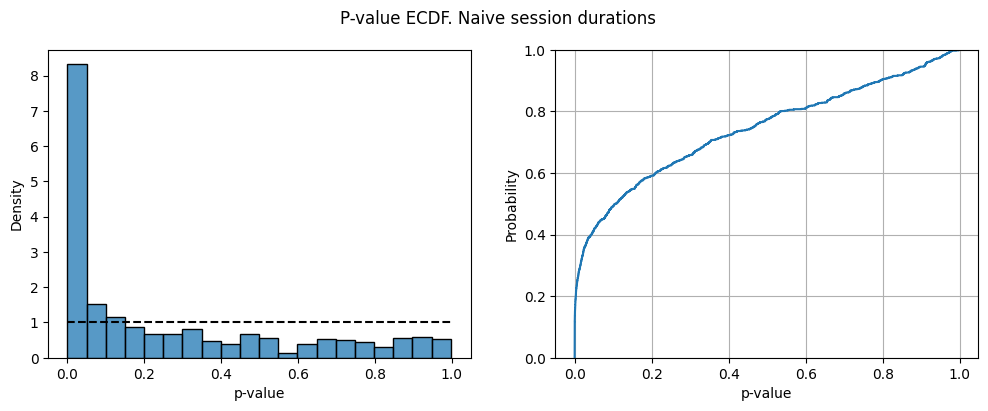

In [7]:
def naive_session_durations(size=100, effect=0):
    def _durations():
        durations = get_session_duration(size=size, effect=effect)
        return np.concatenate(durations)
    return _durations

pvalues = get_pvalue_samples(
    a_sample_generator=naive_session_durations(size=100, effect=0),
    b_sample_generator=naive_session_durations(size=100, effect=0),
    size=1000
)

plot_pvalue_ecdf(pvalues, title='P-value ECDF. Naive session durations')

Мы видим, что полученное распределение сильно неравномерное. Это говорит о неверно сконструированном тесте. 

pvalue < 0.05 примерно в 40% случаев, то есть в 40% случаев мы отклонили нулевую гипотезу, когда она была верна.

Всё это связано с тем, что длины сессий не будут независимыми. Для каждого пользователя вообще говоря будет свое распределение. И неравенство в выборе приводит к таким плачевным результатам.

**Мы уже разобрали примеры с бутстрапом и дельта методом, поэтому разберем только линеризацию**

# Линеризация

In [9]:
def check_linearization(a, b):
    """Проверка гипотезы с помощью линеаризации.
    
    a: List[np.array], список множеств длин сессий пользователей контрольной группы
    b: List[np.array], список множеств длин сессий пользователей пилотной группы
    
    return: pvalue и точечную оценку.
    """
    a_x = np.array([np.sum(row) for row in a])
    a_y = np.array([len(row) for row in a])
    b_x = np.array([np.sum(row) for row in b])
    b_y = np.array([len(row) for row in b])
    coef = np.sum(a_x) / np.sum(a_y)
    a_lin = a_x - coef * a_y
    b_lin = b_x - coef * b_y
    _, pvalue = stats.ttest_ind(a_lin, b_lin)
    delta = np.mean(b_lin) - np.mean(a_lin)
    return pvalue, delta

In [10]:
list_real_delta = []
list_delta = []
list_pvalue = []

for _ in tqdm(range(1000)):
    a = get_session_duration(100)
    b = get_session_duration(100)
    pvalue, delta = check_linearization(a, b)
    list_pvalue.append(pvalue)

  0%|          | 0/1000 [00:00<?, ?it/s]

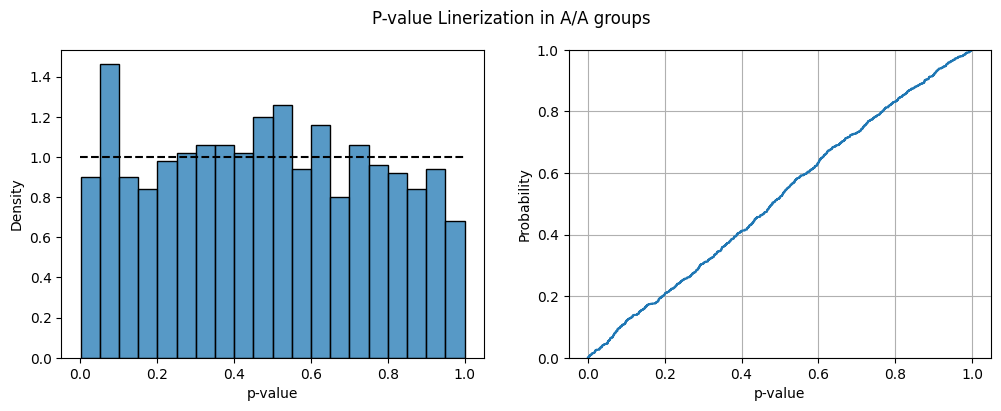

In [11]:
plot_pvalue_ecdf(list_pvalue, title='P-value Linerization in A/A groups')

In [12]:
list_delta = []
list_pvalue = []

for _ in tqdm(range(1000)):
    a = get_session_duration(100)
    b = get_session_duration(100, 0.04)
    pvalue, delta = check_linearization(a, b)
    list_pvalue.append(pvalue)

print('Эффект есть')

  0%|          | 0/1000 [00:00<?, ?it/s]

Эффект есть


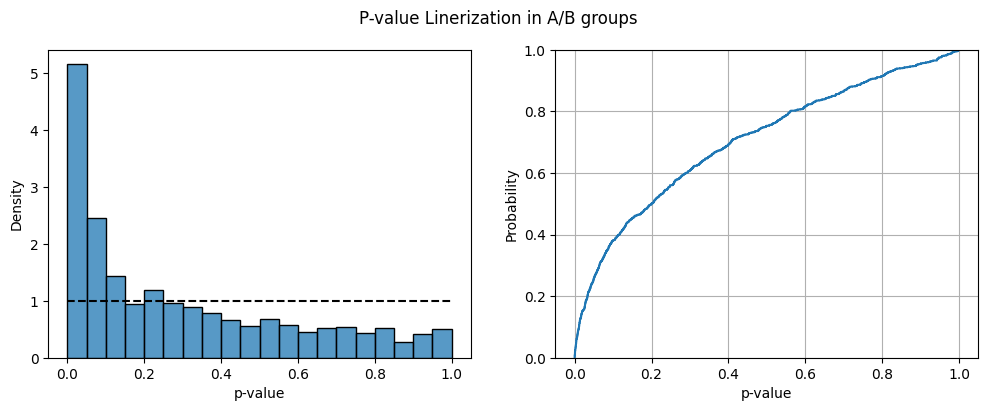

In [13]:
plot_pvalue_ecdf(list_pvalue, title='P-value Linerization in A/B groups')

# Множественная проверка гипотез и ее коррекция

In [14]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import requests, time
import seaborn as sns

from datetime import datetime, timedelta
from io import StringIO
from scipy import stats
from tqdm import tqdm
from statsmodels.stats.weightstats import ztest as ztest
from statsmodels.sandbox.stats.multicomp import multipletests
from statsmodels.stats.power import TTestIndPower
from typing import List

Допустим мы провели эксперимент с 6 вариантами и применили статистический критерий

Итого: 15 попарных проверок (6*5)/2

In [15]:
# Получили следующие значения p-value:
p_values = np.array([0.0029179437568, 0.009391279264, 0.011581441488, 
                     0.012616868376, 0.02839967164, 0.042167014336, 
                     0.04286582096, 0.0956598092, 0.10742021336, 
                     0.15927677808, 0.19332229592, 0.2456475724, 
                     0.254595706, 0.28608461424, 0.3626124616])

In [16]:
# Присвоим порядковые наименования для каждого из тестов
names = ["test" + str(i) for i in range(1, len(p_values) + 1)]
df = pd.DataFrame({"names":names, "p_values":p_values})
df

,names,p_values
0,test1,0.002918
1,test2,0.009391
2,test3,0.011581
3,test4,0.012617
4,test5,0.028400
5,test6,0.042167
6,test7,0.042866
7,test8,0.095660
8,test9,0.107420
9,test10,0.159277


In [17]:
# коррекция Бонферонни: оптимизация FWER
alpha = 0.05
_, bonferroni_p, _, _ = multipletests(df.p_values,alpha=alpha,method='bonferroni')
df["bonferroni_p"] = bonferroni_p
df

,names,p_values,bonferroni_p
0,test1,0.002918,0.043769
1,test2,0.009391,0.140869
2,test3,0.011581,0.173722
3,test4,0.012617,0.189253
4,test5,0.028400,0.425995
5,test6,0.042167,0.632505
6,test7,0.042866,0.642987
7,test8,0.095660,1.000000
8,test9,0.107420,1.000000
9,test10,0.159277,1.000000


In [18]:
# коррекция Холма: более мощная поправка, чем Бонферонни
_, holm_p, _, _ = multipletests(df.p_values, method='holm')
df["holm_p"] = holm_p
df

,names,p_values,bonferroni_p,holm_p
0,test1,0.002918,0.043769,0.043769
1,test2,0.009391,0.140869,0.131478
2,test3,0.011581,0.173722,0.150559
3,test4,0.012617,0.189253,0.151402
4,test5,0.028400,0.425995,0.312396
5,test6,0.042167,0.632505,0.421670
6,test7,0.042866,0.642987,0.421670
7,test8,0.095660,1.000000,0.765278
8,test9,0.107420,1.000000,0.765278
9,test10,0.159277,1.000000,0.955661


In [19]:
# коррекция Бенджамини-Хохберга: коррекция FDR, самая мощная из представленных поправок
_, bh_p, _, _ = multipletests(df.p_values, method='fdr_bh')
df["bh_p"] = bh_p
df

,names,p_values,bonferroni_p,holm_p,bh_p
0,test1,0.002918,0.043769,0.043769,0.043769
1,test2,0.009391,0.140869,0.131478,0.047313
2,test3,0.011581,0.173722,0.150559,0.047313
3,test4,0.012617,0.189253,0.151402,0.047313
4,test5,0.028400,0.425995,0.312396,0.085199
5,test6,0.042167,0.632505,0.421670,0.091855
6,test7,0.042866,0.642987,0.421670,0.091855
7,test8,0.095660,1.000000,0.765278,0.179034
8,test9,0.107420,1.000000,0.765278,0.179034
9,test10,0.159277,1.000000,0.955661,0.238915


**Увидим, что только после BH поправка дает нам возможность отклонить нулевые гипотезы для 4 сравнений**

Поправки Бонферонни и Холма позволяют отклонять нулевую гипотезу только для 1 теста

## Множественное тестирование сравнение методов

In [20]:
import requests, time
import seaborn as sns

from datetime import datetime, timedelta
from io import StringIO
from scipy import stats
from tqdm import tqdm
from statsmodels.stats.weightstats import ztest as ztest
from statsmodels.sandbox.stats.multicomp import multipletests
from statsmodels.stats.power import TTestIndPower
from typing import List

Имеем выдуманный стандартный эксперимент с контрольной и тестовой группами. При этом хотим контролировать вероятность ошибки I рода на заданном уровне 0.05. Сгенерируем данные из нормального распределения с заданными параметрами и убедимся на A/A-тесте, что выбранная статистика (t-test) контролирует ошибку I рода на заданном уровне.



In [21]:
pvalues_list = list()
alpha = 0.05
mu = 5
std = 1
group_size = 200
np.random.seed(42)

for _ in tqdm(range(1000)):
    p_values = list()
    control = np.random.normal(mu, std, group_size)
    treatment = np.random.normal(mu, std, group_size)
    
    pvalue = stats.ttest_ind(control, treatment)[1] # here the probability of a type I error = 0.05
    
    if pvalue < 0.05:
        pvalues_list.append(1)
    else:
        pvalues_list.append(0)

print(f"Ошибка I рода: {np.mean(pvalues_list)}")

100%|████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3841.99it/s]

Ошибка I рода: 0.045


**Добавим в наш эксперимент еще одну тестовую группу**

Теперь эксперимент включает в себя одну контрольную и две тестовые группы, и нам хочется выбрать лучший вариант; а значит придется делать три сравнения: control vs treatment 1, control vs treatment 2, treatment 1 vs treatment 2. Также будем проверять на A/A-тесте, контролируем ли мы ошибку I рода на заданном уровне значимости:



In [22]:
pvalues_list = list()
alpha = 0.05
mu = 5
std = 1
group_size = 200
np.random.seed(42)

for _ in tqdm(range(1000)):
    p_values = list()
    control = np.random.normal(mu, std, group_size)
    treatment1 = np.random.normal(mu, std, group_size)
    treatment2 = np.random.normal(mu, std, group_size)
    
    pvalue_a = stats.ttest_ind(control, treatment1)[1] # здесь вероятность ошибки I рода = 0.05
    pvalue_b = stats.ttest_ind(control, treatment2)[1] # здесь 0.05
    pvalue_c = stats.ttest_ind(treatment1, treatment2)[1] # и здесь 0.05
    
    # итого, вероятность ошибиться хотя бы в одном из случаев = 1 - P(не ошибемся ни разу) = 1 - (0.95 ** 3) ~= 0.14
    
    if pvalue_a < 0.05 or pvalue_b < 0.05 or pvalue_c < 0.05:
        pvalues_list.append(1)
    else:
        pvalues_list.append(0)
  
print(f"Групповая вероятность ошибки I рода: {np.mean(pvalues_list)}")

100%|████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1477.07it/s]

Групповая вероятность ошибки I рода: 0.131


**Получаем вероятность хотя бы раз допустить ошибку I рода при множественном сравнении ~ 0.14**,  что сильно больше ожидаемого значения. Почему так происходит?
Очевидно, потому что мы добавили два дополнительных перекрестных сравнения, благодаря чему вероятность допустить ошибку хотя бы один раз возрастает.

## FWER

Так как мы делаем несколько сравнений внутри эксперимента и можем допустить ошибку I рода несколько раз, можем обобщить вероятность ошибок I рода как вероятность допустить хотя бы одну ошибку I рода (m – число гипотез):


$$
F W E R=P(F P>0)=1-(1-\alpha)^m
$$

Контроль FWER на заданном уровне $\alpha$:
$$
F W E R=P(F P>0)<=\alpha
$$


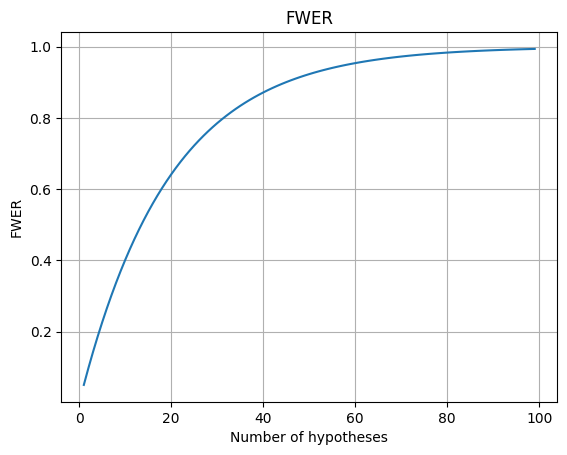

In [23]:
import numpy as np
import matplotlib.pyplot as plt

n_list = np.arange(1, 100)

result = {}

for n in n_list:
    result[n] = 1 - (1 - 0.05) ** n

plt.plot(list(result.keys()), list(result.values()))
plt.title("FWER")
plt.xlabel("Number of hypotheses")
plt.ylabel("FWER")
plt.grid()
plt.show()

FWER быстро растет при росте числа гипотез

### Поправка Бонферрони

Самый простой и интуитивно понятный метод для контроля FWER.

Пусть имеем эксперимент с 10 гипотезами и хотим контролировать FWER на уровне значимости 0.05. Мы помним, что при множественном сравнении ошибка I рода будет быстро накапливаться, причем чем больше гипотез – тем быстрее. Так почему бы нам не занизить изначально наши уровни значимости пропорционально числу гипотез? Так мы гарантируем, что будем контролировать ошибку I рода на заданном уровне.

Итак, мы хотим контролировать FWER на уровнях значимости $\alpha_1..\alpha_m$. Наша задача выбрать $\alpha_1..\alpha_m$ так, чтобы $FWER  \le\alpha$. Тогда определим наши уровни значимости $\alpha_1..\alpha_m$ как $\alpha_i / m.$

#### Методы расчета

In [24]:
def method_without_correct(p_values: List[float], alpha: float = 0.05):
    """The function returns the comparison result without corrections"""
    
    res = (np.array(p_values) <= alpha).astype(int)
    return res

def method_bonferroni(p_values: List[float], alpha: float = 0.05):
    """The function returns the comparison result with Bonferroni correction"""
    
    return (multipletests(p_values, alpha=alpha, method="bonferroni")[0]).astype(int)

def method_holm(p_values: List[float], alpha: float = 0.05):
    """The function returns the comparison result with Holm correction"""
    
    return (multipletests(p_values, alpha=alpha, method="holm")[0]).astype(int)


def method_benjamini_hochberg(p_values: List[float], alpha: float = 0.05):
    """The function returns the comparison result with Benjamini-Hochberg correction"""
    
    return (multipletests(p_values, alpha=alpha, method="fdr_bh")[0]).astype(int)

In [25]:
def draw_plot(methods: List[str], num_of_tests: List[int], metric: str, result: dict, title: str) -> None:
    """Visualization of a plot of errors depending on the number of comparisons"""
    
    sns.set(style="darkgrid")
    fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=200)
    
    method_markup = dict()
    
    for method in methods:
        if method == "without_correct":
            method_markup[method] = ["-v"]
        elif method == "bonferroni":
            method_markup[method] = ["-o"]
        elif method == "holm":
            method_markup[method] = ["-o"]
        else:
            method_markup[method] = ["->"]
    
    if metric in ("fwer", "fdr"):
        ax.hlines(alpha, 0, max(num_of_tests), linestyles='--', label=f"alpha={alpha}", color="red")
    else:
        ax.hlines(0.2, 0, max(num_of_tests), linestyles='--', label="beta=0.2", color='r')
    
    for method, value in result.items():
        ax.plot(value.keys(), value.values(), method_markup[method][0], label=method, alpha=0.7)
        ax.legend(fontsize=12)
        ax.set_title(title)
        ax.set_xlabel("Experiments, num")
        ax.set_ylabel(title)
    
    return


In [26]:
def get_errors(result: dict, metric: str, methods: list, num_of_tests: list, no_effect_type: int) -> dict:
    """Function for calculating errors"""
    
    errors_dict = {
        method_name: {
            num: []
            for num in num_of_tests
        }
        for method_name in methods
    }

    for method, params in result.items():
        if metric == "fdr":
            for cnt, val in params.items():
                if no_effect_type == -1:
                    cnt_groups_no_effects = 1
                elif no_effect_type == 0:
                    cnt_groups_no_effects = cnt // 2
                else:
                    cnt_groups_no_effects = cnt - 1
                fp = np.array(val["first"]) * (cnt - cnt_groups_no_effects)
                tp = (1 - np.array(val["second"])) * cnt
                fp_tp = fp + tp
                fp_tp[fp_tp < 1] = 1
                errors_dict[method][cnt] = np.mean(fp / fp_tp)
        elif metric == "fwer":
            for cnt, val in params.items():
                errors_dict[method][cnt] = np.mean(np.array(val["first"]) > 0)
        elif metric == "error_type_II":
            for cnt, val in params.items():
                errors_dict[method][cnt] = np.mean(val["second"])
        else:
            for cnt, val in params.items():
                errors_dict[method][cnt] = np.mean(np.array(val["second"]) > 0)

    return errors_dict


In [27]:
def construct_groups(num: int, cnt_groups_no_effects: int, metric: str, 
                     mu: float, std: float, group_size: str, effect: float) -> list:
    """Function for forming groups"""
    
    groups_list = list()
    
    for _ in range(num):
        if metric == "fwer":
            groups_list.append((np.random.normal(mu, std, group_size), np.random.normal(mu, std, group_size)))
        elif metric in ("fwer II", "error_type_II"):
            groups_list.append((np.random.normal(mu, std, group_size),
                    np.random.normal(mu * (1 + effect), std, group_size)
                )
            )
        else:
            for _ in range(cnt_groups_no_effects):
                groups_list.append((np.random.normal(mu, std, group_size), np.random.normal(mu, std, group_size)))

            for _ in range(num - cnt_groups_no_effects):
                groups_list.append((np.random.normal(mu, std, group_size),
                        np.random.normal(mu * (1 + effect), std, group_size)
                    )
                )
    return groups_list

In [28]:
def get_plot_metrics(methods: list, num_of_tests: list, metric: str, 
                     title: str, group_size: int = 100, effect: float = 0.0,
    mu: float = 5.0, std: float = 1, n_iter: int = 300, alpha: float = 0.05, no_effect_type: int = 0) -> None:
    """"""
    if metric not in ("fwer", "fwer II", "fdr", "error_type_II"):
        return "Incorrect Method Name"
    
    result = {
        method: {num: {"first": [], "second": []} for num in num_of_tests} for method in methods
    }
    
    
    for num in tqdm(num_of_tests):
        cnt_groups_no_effects = 0
        if metric == "fdr":
            if no_effect_type == -1:
                cnt_groups_no_effects = 1
            elif no_effect_type == 0:
                cnt_groups_no_effects = num // 2
            else:
                cnt_groups_no_effects = num - 1
        
        for _ in range(n_iter):
            groups_list = construct_groups(num, cnt_groups_no_effects, metric, mu, std, group_size, effect)

            p_values = list()
    
            for control, treatment in groups_list:
                p_values.append(stats.ttest_ind(control, treatment)[1])

            for method in methods:
                if method == "without_correct":
                    func = method_without_correct
                elif method == "bonferroni":
                    func = method_bonferroni
                elif method == "holm":
                    func = method_holm
                else:
                    func = method_benjamini_hochberg
                
                if metric in ("fwer", "fwer II", "error_type_II"):
                    result[method][num]["first"].append(np.mean(func(p_values)))
                    result[method][num]["second"].append(
                        1 - np.mean(func(p_values))
                    )
                else:
                    result[method][num]["first"].append(np.mean(func(p_values)[:cnt_groups_no_effects]))
                    result[method][num]["second"].append(
                        1 - np.mean(func(p_values)[cnt_groups_no_effects:])
                    )

    errors = get_errors(result, metric, methods, num_of_tests, no_effect_type)
    
    draw_plot(methods, num_of_tests, metric, errors, title)

    return 


### FWER

In [48]:
num_of_tests = [1, 2, 3, 5, 10, 30, 50]

methods = [
    "without_correct",
    "bonferroni",
#     "holm",
#     "benjamini-hochberg"
]

In [44]:
power_analysis = TTestIndPower()

effect_size = power_analysis.solve_power(
    power=0.8, 
    alpha=0.05,
    nobs1=100,
    alternative="two-sided"
)

print(f"Effect size (MDE) to add to test group: {round(effect_size, 3)}")

Effect size (MDE) to add to test group: 0.398


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.56s/it]


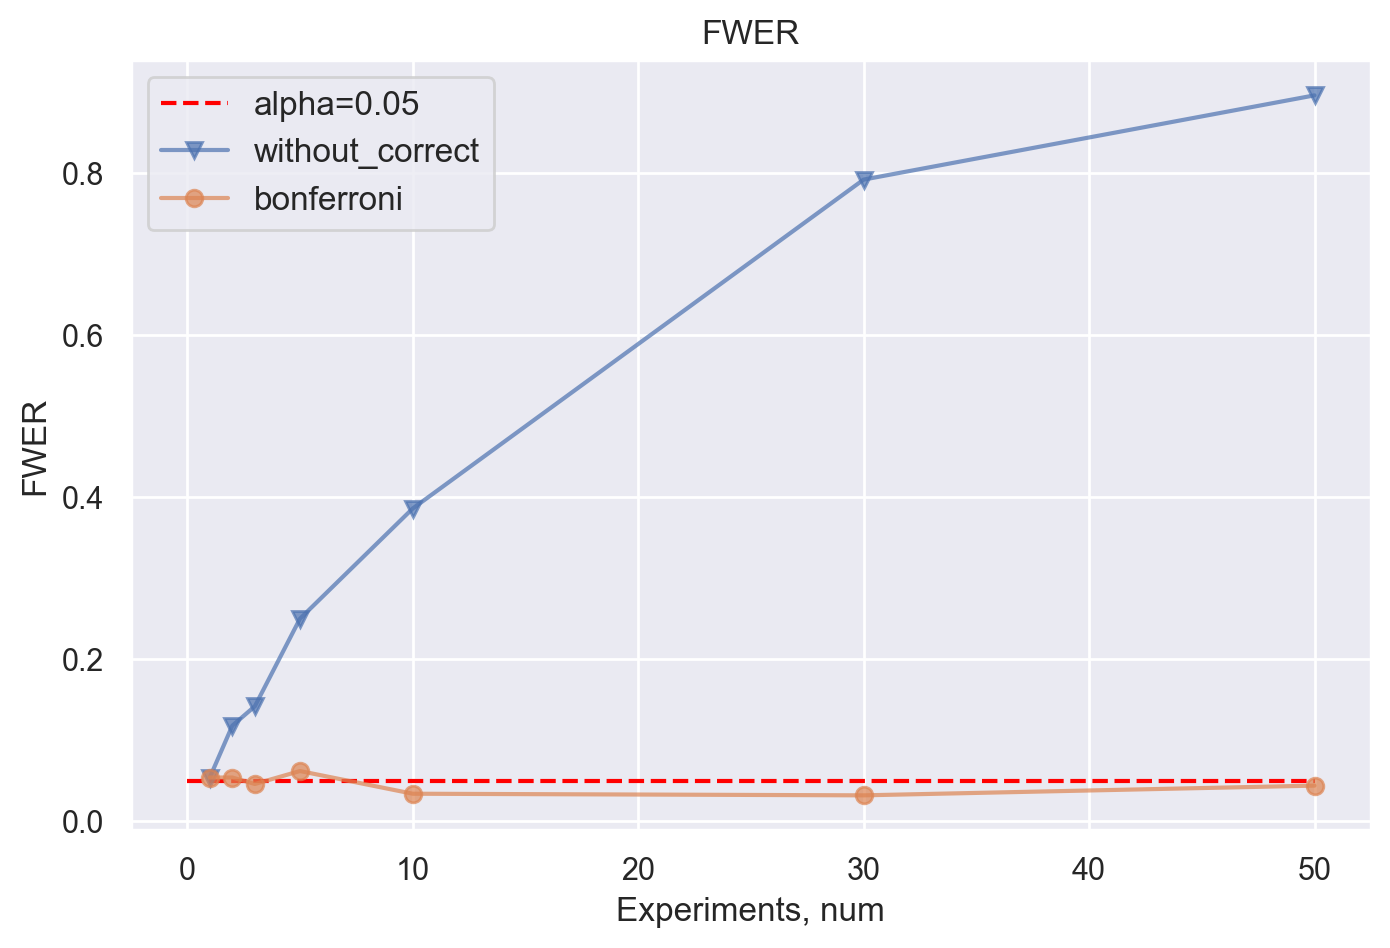

In [49]:
get_plot_metrics(
    methods, # list of methods for comparing
    num_of_tests, # list of number of comparings
    "fwer", # type error for drawing
    "FWER", # title and ylabel for plot
    group_size=100,
    effect=0.0,
    mu=5.0,
    std=1,
    n_iter=500,
    alpha=0.05
)

Можем наблюдать, как метод Бонферрони отлично контролирует FWER. Тогда как метод без корректировки уже на десяти сравнениях "накопил" $FWER  \sim 0.4$



**Проблема метода Бонферрони в том**, что таким образом мы сильно перестраховываемся в отношении ошибки I рода, тем самым пропуская истинные эффекты, то есть **уменьшаем мощность эксперимента с ростом числа гипотез**.

Можем смоделировать эксперимент с разным количеством гипотез и посчитать аналог FWER для ошибки II рода – групповую вероятность ошибки II рода или вероятность допустить хотя бы одну ошибку II рода. Чтобы посчитать такую вероятность, будем добавлять эффект к treatment группе и считать долю случаев, когда мы не нашли эффект, хотя на самом деле он есть.

**Смоделируем ошибки 2 рода**

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:22<00:00,  3.28s/it]


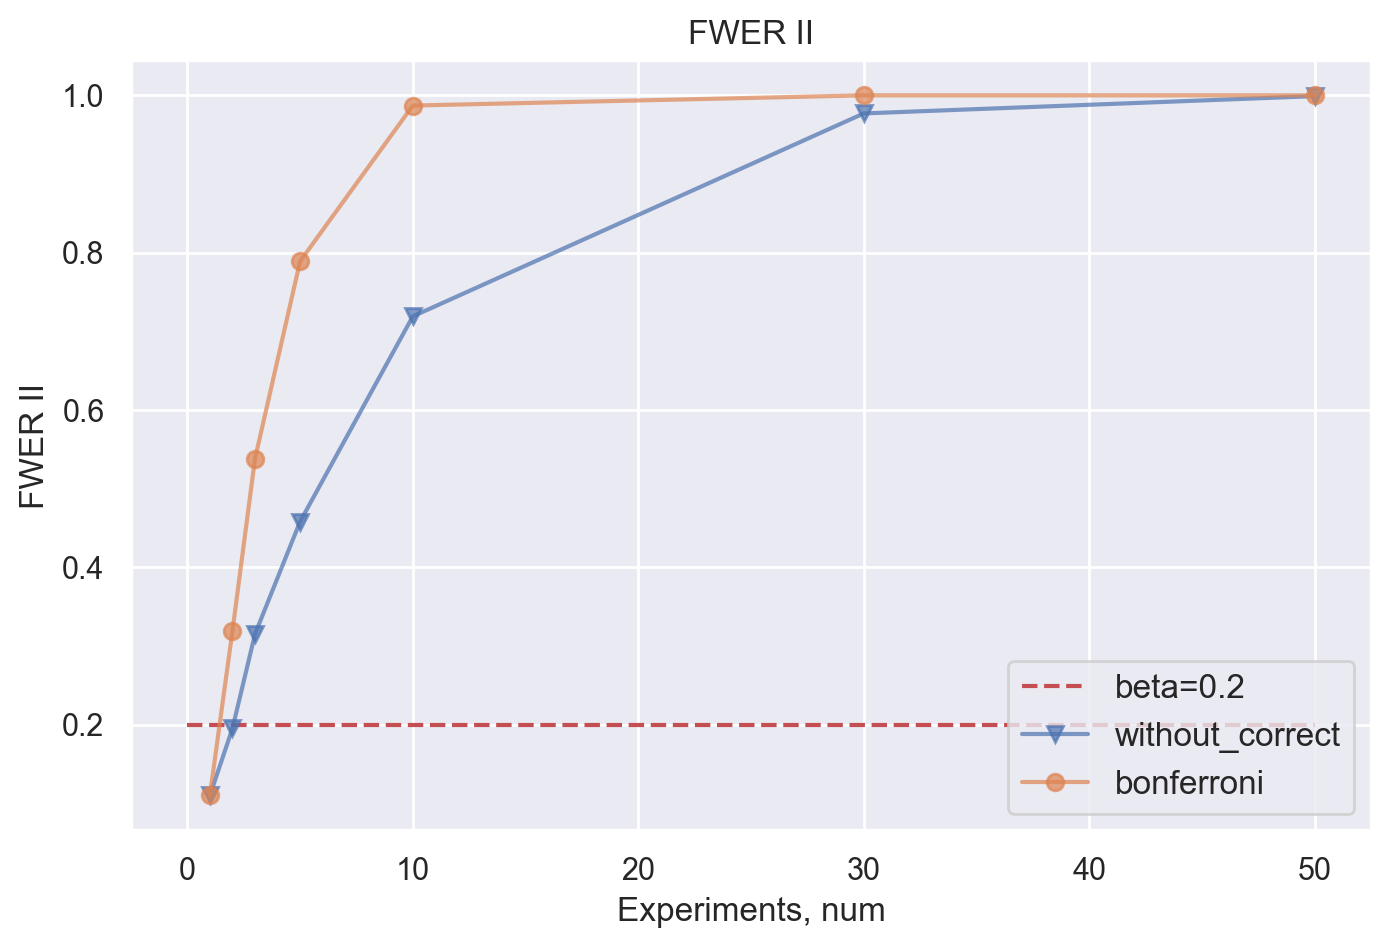

In [50]:
get_plot_metrics(
    methods,
    num_of_tests,
    "fwer II",
    "FWER II",
    group_size=500, # Added a larger sample size to make the graph more readable
    effect=0.0398, # mde
    mu=5,
    std=1,
    n_iter=1000,
    alpha=0.05
)

Обобщая, хорошо заметна тенденция быстрого роста групповой вероятности ошибки II рода при использовании метода Бонферрони по сравнению с методом без поправок.

**Мощность метода Бонферрони ниже, чем без него**

## Метод Холма

Процедура Холма равномерно мощнее метода Бофнеррони.

Вновь посмотрим на модельные данные для демонстрации уровня контроля FWER методом Холма, сравнивая в том числе с методом Бонферрони.

In [51]:
methods = [
    "without_correct",
    "bonferroni",
    "holm",
#     "benjamini-hochberg"
]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:35<00:00, 30.80s/it]


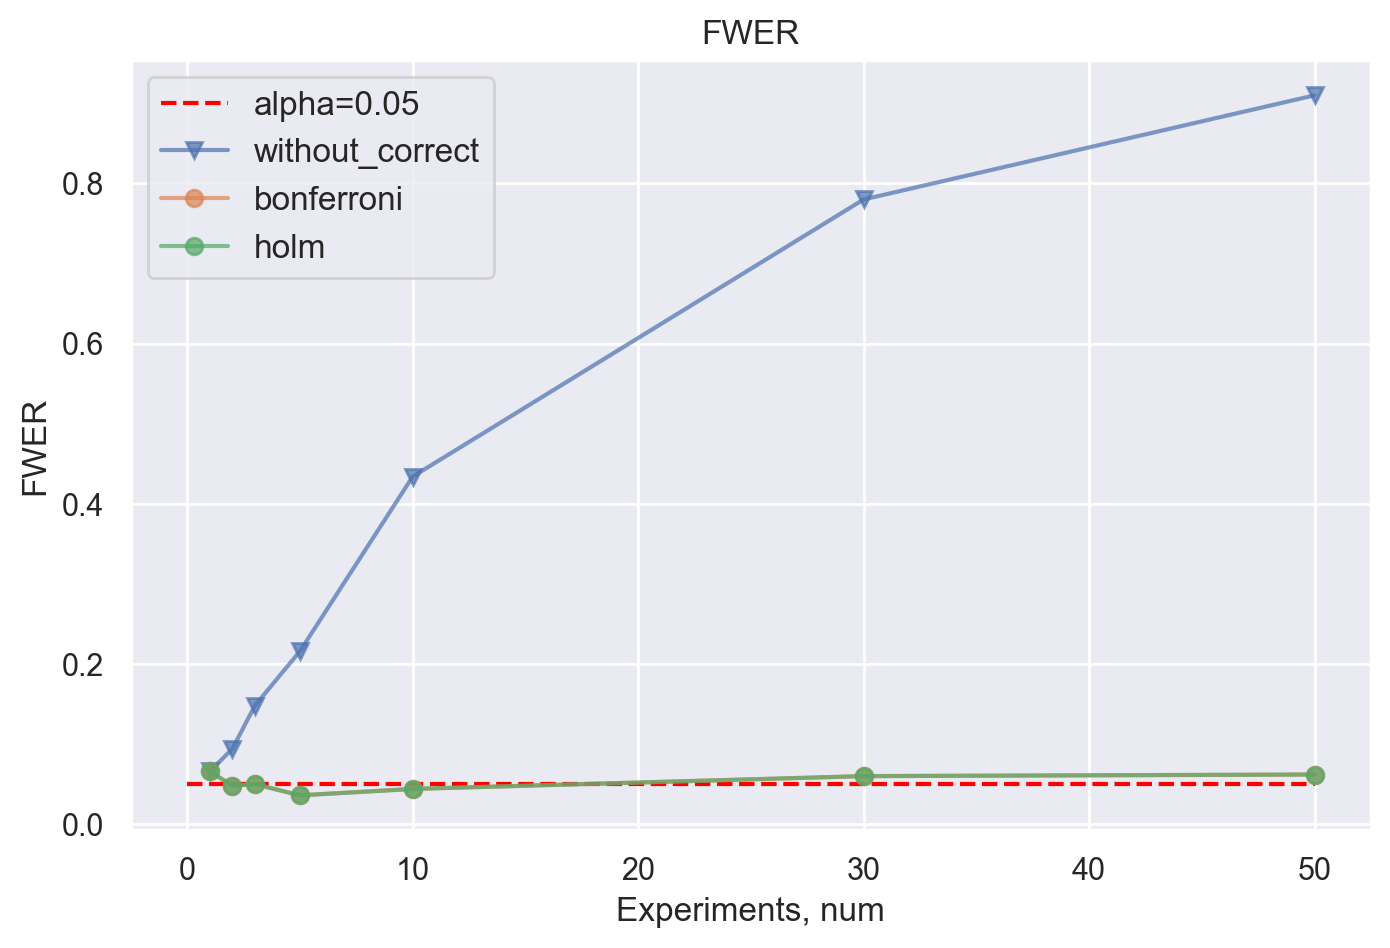

In [52]:
get_plot_metrics(
    methods,
    num_of_tests,
    "fwer",
    "FWER",
    group_size=100,
    effect=0.0,
    mu=5,
    std=1,
    n_iter=500,
    alpha=0.05,
)

**Метод Холма, как и метод Бонферрони контролируют FWER на заданном уровне**, в отличие от метода без использования поправок.

Вновь посмотрим на **групповую вероятность ошибки II рода**, добавив на график метод Холма.

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:33<00:00, 30.56s/it]


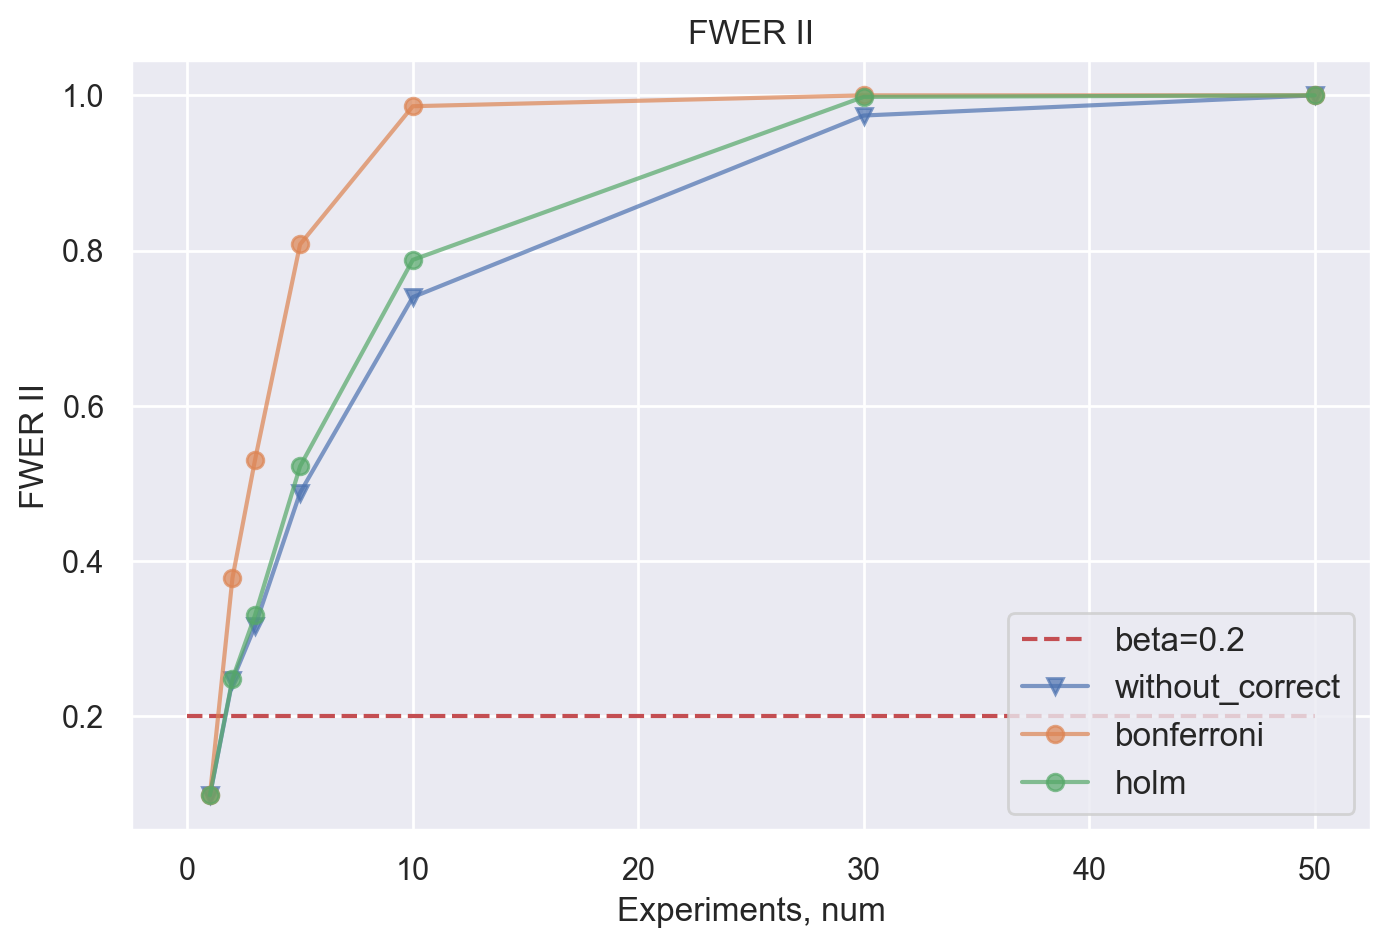

In [55]:
get_plot_metrics(
    methods,
    num_of_tests,
    "fwer II",
    "FWER II",
    group_size=500,
    effect=0.0398,
    mu=5,
    std=1,
    n_iter=500,
    alpha=0.05
)

Видим, что метод Холма заметно "мощнее" метода Бонферрони: значение групповой вероятности ошибки II рода при использовании метода Холма при любом числе экспериментов не выше, чем при использовании поправки Бонферрони.



Все методы, о которых мы говорили выше, контролируют FWER. Но также все они уменьшают мощность с ростом числа экспериментов: какой-то метод снижает мощность сильно (Бонферрони), какие-то методы равномерно более мощные, но все еще приходится расплачиваться мощностью (Холм, Шидак-Холм).

**При этом без дополнительных предположений нельзя построить процедуру более мощную, чем метод Холма**. А при условии независимости статистик, нельзя построить процедуру более мощную, чем метод Шидака-Холма.

Контроль FWER в некоторых ситуациях может быть неоправданно жестким, так как мы пытаемся контролировать совершить хотя бы одну ошибку I рода. Но мы также можем пытаться контролировать, например, долю ложноположительных результатов.



## FDR

FDR – это ожидаемая доля ложных отклонений от всех отклонений нулевых гипотез.

$$
FDR = \left(\frac{FP}{FP + TP}\right)
$$

С помощью FDR мы задаем не количество ошибок первого рода в принципе, а количество ложноположительных ( fp) результатов в отношении к истинно-
положительным (tp) и ложноположительным ( fp) (далее это число обозначается как γ)

На интуитивном уровне отличие FDR от FWER в том, что FDR более "мягко" контролирует ошибку I рода, но также учитывает (в знаменателе) и ошибку II рода. За счет этого методы, контролирующие FDR, более мощные, но в то же время не так жестко контролируют ошибку I рода.



**Для контроля FDR используется поправка Бенджамини-Хохберга**

Один из методов для контроля ожидаемой доли ложных отклонений (FDR). Этот метод обеспечивает контроль FDR на заданном уровне \alpha (при условии независимости статистик).



Для моделирования FDR мы будем добавлять эффект к части экспериментальных групп. Смоделируем три крайних ситуации, чтобы увидеть наиболее полную картину поведения методов при контроле FDR:

- половина гипотез с эффектом, половина – без эффекта

- одна гипотеза из всех с эффектом, остальные – без эффекта

- одна гипотеза из всех без эффекта, остальные – с эффектом


**Половина гипотез с эффектом, половина – без эффекта**



In [58]:
methods = [
    "without_correct",
    "bonferroni",
    "holm",
    "benjamini-hochberg"
]

  0%|                                                                                                                             | 0/7 [00:00<?, ?it/s]/Users/ruapvdb/PycharmProjects/env/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ruapvdb/PycharmProjects/env/venv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [09:07<00:00, 78.25s/it]


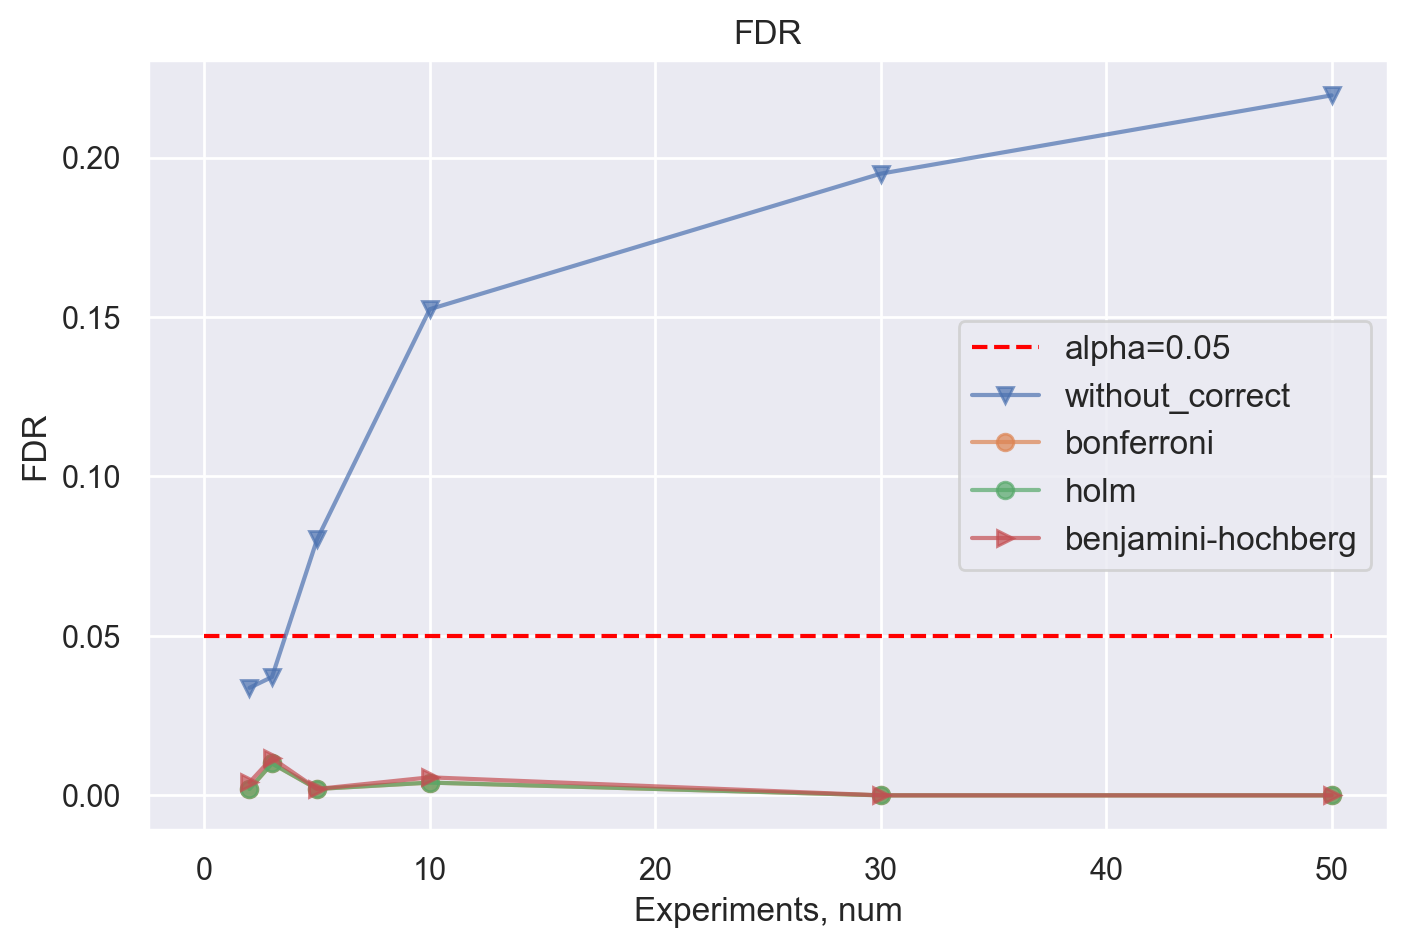

In [59]:
get_plot_metrics(
    methods,
    num_of_tests,
    "fdr",
    "FDR",
    group_size=20,
    effect=0.0398,
    mu=5,
    std=1,
    n_iter=500,
    alpha=0.05,
    no_effect_type=0
)

Отметим, что хуже всего справляется метод без каких-либо поправок, что неудивительно. Как неудивительно и то, что методы Холма и Бонферрони контролируют FDR на низком уровне за счет своей более консервативной природы. Метод Бенджамини-Хохберга контролирует FDR на заданном уровне.



**Одна гипотеза из всех без эффекта, остальные – с эффектом**

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [09:08<00:00, 78.30s/it]


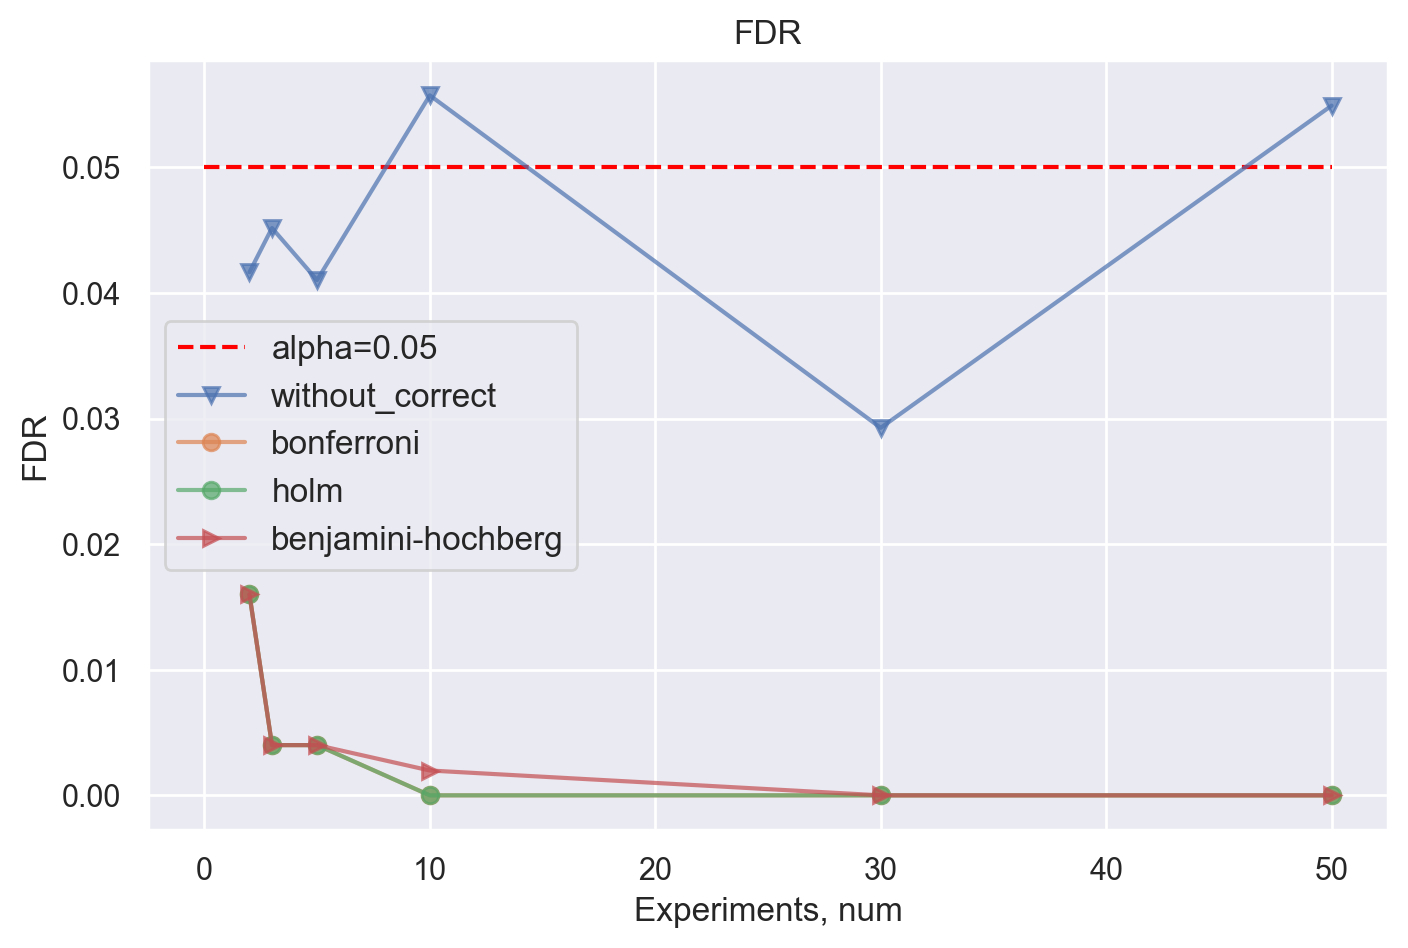

In [61]:
get_plot_metrics(
    methods,
    num_of_tests,
    "fdr",
    "FDR",
    group_size=20,
    effect=0.0398,
    mu=5,
    std=1,
    n_iter=500,
    alpha=0.05,
    no_effect_type=-1
)

**Одна гипотеза из всех с эффектом, остальные – без эффекта**

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [09:06<00:00, 78.14s/it]


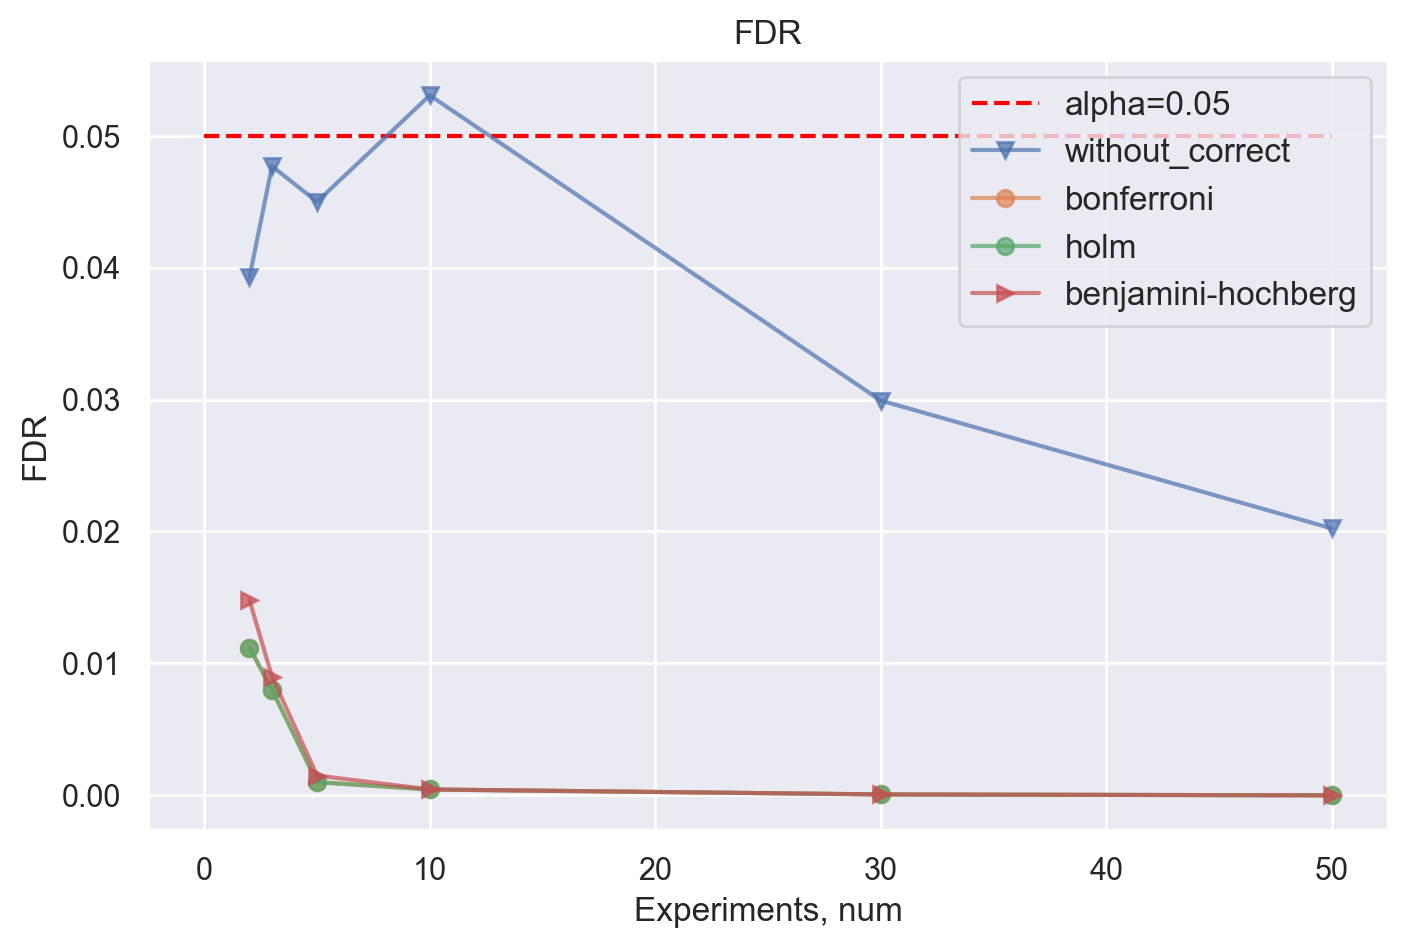

In [63]:
get_plot_metrics(
    methods,
    num_of_tests,
    "fdr",
    "FDR",
    group_size=20,
    effect=0.0398,
    mu=5,
    std=1,
    n_iter=500,
    alpha=0.05,
    no_effect_type=1
)

Для начала разберемся с метрикой: как выбрать между FWER, FDR или еще чем-то?

Как часто бывает, правильного ответа тут нет. Все зависит от конкретного кейса.

- Если имеется множество гипотез, из которых хочется выбрать наиболее "интересные" для дальнейшего анализа, можно опираться на FDR: так мы будем пропускать меньше реальных эффектов, а строгость в отношении ошибки I рода не так важна

- Если гипотез немного и тестируется фича, которая потенциально сильно может сказаться на ключевых метриках (например, на деньгах) как отрицательно (в особенности), так и положительно – надежней использовать FWER в силу его бОльшей консервативности в отношении ошибки I рода